In [2]:
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.distributions.util import gather
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam

%matplotlib inline
#assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)
#smoke_test = ('CI' in os.environ)

In [3]:
def get_dynamics(num_frames):
    time = torch.arange(float(num_frames)) / 4
    return torch.stack([time.cos(), time.sin()], -1)

In [4]:
def generate_data(args):
    # Object model.
    num_objects = int(round(args.expected_num_objects))  # Deterministic.
    print("num of objects {}".format(num_objects))
    states = dist.Normal(0., 1.).sample((num_objects, 2))
    print("states {}".format(states))
    
    # Detection model.
    emitted = dist.Bernoulli(args.emission_prob).sample((args.num_frames, num_objects))
    print("emitted {}".format(emitted))
    num_spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,))
    print("num spurious {}".format(num_spurious))
    max_num_detections = int((num_spurious + emitted.sum(-1)).max())
    print("max num detections {}".format(max_num_detections))
    observations = torch.zeros(args.num_frames, max_num_detections, 1+1) # position+confidence
    print("observations {}".format(observations.shape))
    positions = get_dynamics(args.num_frames).mm(states.t())
    print("positions {}".format(positions))
    noisy_positions = dist.Normal(positions, args.emission_noise_scale).sample()
    print("noisy positions {}".format(noisy_positions))
    for t in range(args.num_frames):
        print("t {}".format(t))
        j = 0
        print("j {}".format(j))
        for i, e in enumerate(emitted[t]):
            if e:
                observations[t, j, 0] = noisy_positions[t, i]
                observations[t, j, 1] = 1
                print("obs {} {}".format(j, observations[t, j, 0]))
                j += 1
        n = int(num_spurious[t])
        if n:
            observations[t, j:j+n, 0] = dist.Normal(0., 1.).sample((n,))
            observations[t, j:j+n, 1] = 1
            print("spur obs {} {}".format(j+n, observations[t,j:j+n,0]))

    return states, positions, observations

In [5]:
pyro.set_rng_seed(0)
true_states, true_positions, observations = generate_data(args)
true_num_objects = len(true_states)
max_num_detections = observations.shape[1]
assert true_states.shape == (true_num_objects, 2)
assert true_positions.shape == (args.num_frames, true_num_objects)
assert observations.shape == (args.num_frames, max_num_detections, 1+1)
print("generated {:d} detections from {:d} objects".format(
    (observations[..., -1] > 0).long().sum(), true_num_objects))

NameError: name 'args' is not defined

In [55]:
observations[..., -1]

tensor([[1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 0.]])

In [6]:
def model(args, observations):
    with pyro.plate("objects", args.max_num_objects):
        exists = pyro.sample("exists",
                             dist.Bernoulli(args.expected_num_objects / args.max_num_objects))
        print("exists {}".format(exists))
        with poutine.mask(mask=exists.byte()):
            states = pyro.sample("states", dist.Normal(0., 1.).expand([2]).to_event(1))
            positions = get_dynamics(args.num_frames).mm(states.t())
        print("states {}".format(states))
        print("positions {}".format(positions))
    with pyro.plate("detections", observations.shape[1]):
        with pyro.plate("time", args.num_frames):
            # The combinatorial part of the log prob is approximated to allow independence.
            is_observed = (observations[..., -1] > 0)
            print("is observed {}".format(is_observed))
            with poutine.mask(mask=is_observed):
                assign = pyro.sample("assign",
                                     dist.Categorical(torch.ones(args.max_num_objects + 1)))
            print("assign {}".format(assign))
            is_spurious = (assign == args.max_num_objects)
            print("is spurious {}".format(is_spurious))
            is_real = is_observed & ~is_spurious
            print("is real {}".format(is_real))
            num_observed = is_observed.float().sum(-1, True)
            print("num obser {}".format(num_observed))
            pyro.sample("is_real",
                        dist.Bernoulli(args.expected_num_objects / num_observed),
                        obs=is_real.float())
            pyro.sample("is_spurious",
                        dist.Bernoulli(args.expected_num_spurious / num_observed),
                        obs=is_spurious.float())

            # The remaining continuous part is exact.
            observed_positions = observations[..., 0]
            with poutine.mask(mask=is_real):
                bogus_position = positions.new_zeros(args.num_frames, 1)
                augmented_positions = torch.cat([positions, bogus_position], -1)
                predicted_positions = gather(augmented_positions, assign, -1)
                pyro.sample("real_observations",
                            dist.Normal(predicted_positions, args.emission_noise_scale),
                            obs=observed_positions)
            with poutine.mask(mask=is_spurious):
                pyro.sample("spurious_observations", dist.Normal(0., 1.),
                            obs=observed_positions)

In [57]:
model(args, observations)

exists tensor([1., 1., 0.])
states tensor([[ 1.8042, -2.2858],
        [ 0.0700,  0.6674],
        [-1.0403, -0.4820]])
positions tensor([[ 1.8042,  0.0700, -1.0403],
        [ 1.1827,  0.2329, -1.1272],
        [ 0.4875,  0.3813, -1.1440],
        [-0.2379,  0.5061, -1.0897],
        [-0.9486,  0.5994, -0.9676]])
is observed tensor([[ True,  True, False],
        [ True,  True,  True],
        [ True,  True, False],
        [ True,  True,  True],
        [ True,  True, False]])
assign tensor([[2, 1, 2],
        [0, 1, 0],
        [2, 0, 1],
        [1, 3, 2],
        [2, 3, 3]])
is spurious tensor([[False, False, False],
        [False, False, False],
        [False, False, False],
        [False,  True, False],
        [False,  True,  True]])
is real tensor([[ True,  True, False],
        [ True,  True,  True],
        [ True,  True, False],
        [ True, False,  True],
        [ True, False, False]])
num obser tensor([[2.],
        [3.],
        [2.],
        [3.],
        [2.]])


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 1

In [12]:
def guide(args, observations):
    # Initialize states randomly from the prior.
    states_loc = pyro.param("states_loc", lambda: torch.randn(args.max_num_objects, 2))
    states_scale = pyro.param("states_scale",
                              lambda: torch.ones(states_loc.shape) * args.emission_noise_scale,
                              constraint=constraints.positive)
    positions = get_dynamics(args.num_frames).mm(states_loc.t())

    # Solve soft assignment problem.
    real_dist = dist.Normal(positions.unsqueeze(-2), args.emission_noise_scale)
    spurious_dist = dist.Normal(0., 1.)
    is_observed = (observations[..., -1] > 0)
    observed_positions = observations[..., 0].unsqueeze(-1)
    assign_logits = (real_dist.log_prob(observed_positions) -
                     spurious_dist.log_prob(observed_positions) +
                     math.log(args.expected_num_objects * args.emission_prob /
                              args.expected_num_spurious))
    assign_logits[~is_observed] = -float('inf')
    exists_logits = torch.empty(args.max_num_objects).fill_(
        math.log(args.max_num_objects / args.expected_num_objects))
    assignment = MarginalAssignmentPersistent(exists_logits, assign_logits)

    with pyro.plate("objects", args.max_num_objects):
        exists = pyro.sample("exists", assignment.exists_dist, infer={"enumerate": "parallel"})
        with poutine.mask(mask=exists.byte()):
            pyro.sample("states", dist.Normal(states_loc, states_scale).to_event(1))
    with pyro.plate("detections", observations.shape[1]):
        with poutine.mask(mask=is_observed):
            with pyro.plate("time", args.num_frames):
                assign = pyro.sample("assign", assignment.assign_dist, infer={"enumerate": "parallel"})

    return assignment

In [13]:
args = type('Args', (object,), {})  # A fake ArgumentParser.parse_args() result.

args.num_frames = 5
args.max_num_objects = 3
args.expected_num_objects = 2.
args.expected_num_spurious = 1.
args.emission_prob = 0.8
args.emission_noise_scale = 0.1

assert args.max_num_objects >= args.expected_num_objects



In [14]:
pyro.set_rng_seed(0)
true_states, true_positions, observations = generate_data(args)
true_num_objects = len(true_states)
max_num_detections = observations.shape[1]
assert true_states.shape == (true_num_objects, 2)
assert true_positions.shape == (args.num_frames, true_num_objects)
assert observations.shape == (args.num_frames, max_num_detections, 1+1)
print("generated {:d} detections from {:d} objects".format(
    (observations[..., -1] > 0).long().sum(), true_num_objects))

num of objects 2
states tensor([[ 1.5410, -0.2934],
        [-2.1788,  0.5684]])
emitted tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.]])
num spurious tensor([0., 1., 0., 1., 1.])
max num detections 3
observations torch.Size([5, 3, 2])
positions tensor([[ 1.5410, -2.1788],
        [ 1.4205, -1.9704],
        [ 1.2117, -1.6395],
        [ 0.9275, -1.2067],
        [ 0.5857, -0.6989]])
noisy positions tensor([[ 1.5819, -2.0366],
        [ 1.4354, -2.0375],
        [ 1.1903, -1.6827],
        [ 0.8567, -1.2174],
        [ 0.4614, -0.7465]])
t 0
j 0
obs 0 1.5818676948547363
obs 1 -2.0366475582122803
t 1
j 0
obs 0 1.4354344606399536
obs 1 -2.0375099182128906
spur obs 3 tensor([-0.6859])
t 2
j 0
obs 0 1.1902554035186768
obs 1 -1.682744026184082
t 3
j 0
obs 0 0.8567293286323547
obs 1 -1.217374563217163
spur obs 3 tensor([-1.5051])
t 4
j 0
obs 0 0.46141868829727173
spur obs 2 tensor([0.2550])
generated 12 detections from 2 objects


In [15]:
def plot_solution(message=''):
    assignment = guide(args, observations)
    states_loc = pyro.param("states_loc")
    positions = get_dynamics(args.num_frames).mm(states_loc.t())
    pyplot.figure(figsize=(12,6)).patch.set_color('white')
    pyplot.plot(true_positions.numpy(), 'k--')
    is_observed = (observations[..., -1] > 0)
    pos = observations[..., 0]
    time = torch.arange(float(args.num_frames)).unsqueeze(-1).expand_as(pos)
    pyplot.scatter(time[is_observed].view(-1).numpy(),
                   pos[is_observed].view(-1).numpy(), color='k', marker='+',
                   label='observation')
    for i in range(args.max_num_objects):
        p_exist = assignment.exists_dist.probs[i].item()
        position = positions[:, i].detach().numpy()
        pyplot.plot(position, alpha=p_exist, color='C0')
    pyplot.title('Truth, observations, and predicted tracks ' + message)
    pyplot.plot([], 'k--', label='truth')
    pyplot.plot([], color='C0', label='prediction')
    pyplot.legend(loc='best')
    pyplot.xlabel('time step')
    pyplot.ylabel('position')
    pyplot.tight_layout()

In [16]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
plot_solution('(before training)')

ValueError: Expected mask to be a ByteTensor but got <class 'torch.Tensor'>

In [36]:
infer = SVI(model, guide, Adam({"lr": 0.005}), TraceEnum_ELBO(max_plate_nesting=2))
losses = []
for epoch in range(101):
    loss = infer.step(args, observations)
    if epoch % 10 == 0:
        print("epoch {: >4d} loss = {}".format(epoch, loss))
    losses.append(loss)

epoch    0 loss = 191.8911590576172
epoch   10 loss = 185.81822204589844
epoch   20 loss = 179.74937438964844
epoch   30 loss = 180.95166015625
epoch   40 loss = 179.11683654785156
epoch   50 loss = 180.42613220214844
epoch   60 loss = 176.9592742919922
epoch   70 loss = 178.4936981201172
epoch   80 loss = 179.39280700683594
epoch   90 loss = 179.5439910888672
epoch  100 loss = 178.70132446289062


In [44]:
for epoch in range(11):
    loss = infer.step(args, observations)
    if epoch % 10 == 0:
        print("epoch {: >4d} loss = {}".format(epoch, loss))
    losses.append(loss)

ValueError: The parameter loc has invalid values
Trace Shapes:    
 Param Sites:    
   states_loc 3 2
 states_scale 3 2
Sample Sites:    
Trace Shapes:    
 Param Sites:    
   states_loc 3 2
 states_scale 3 2
Sample Sites:    

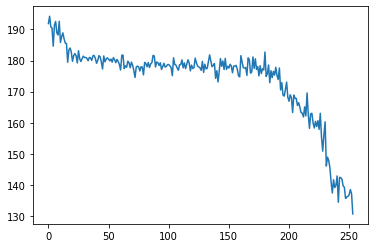

In [41]:
pyplot.plot(losses);

In [42]:
plot_solution('(after training)')

ValueError: The parameter loc has invalid values